In [ ]:
# Uncomment and run in a separate Colab cell:
!pip install google-generativeai pandas tqdm requests

# For Google Drive access (run in Colab):
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Setup complete!
✅ Configuration loaded!
📁 Input:  /content/drive/MyDrive/Duroflex/Store Conversion/staff quality proxy via Gmb call pilot.csv
📁 Output: /content/drive/MyDrive/Duroflex/Store Conversion/staff_quality_analysis_results.csv
✅ API key loaded from Colab Secrets
✅ Processing prompt loaded!
✅ Core modules loaded! (File API Enabled)
✅ Pipeline class loaded!
[05:42:35] ✅: Gemini initialized: gemini-flash-latest

📞 GMB CALL ANALYSIS PIPELINE

[05:42:35] INFO: Found checkpoint, loading...
📊 Total rows: 187
✅ Already processed: 104
🔄 To process: 83



Processing calls:   0%|          | 0/83 [00:00<?, ?it/s]

[05:42:35] INFO: Downloading: https://recordings.dashloc.com/2025/12/4208/inbound/90351677...
[05:42:39] INFO: Downloaded 1,792,684 bytes
[05:43:02] INFO: Downloading: https://recordings.dashloc.com/2025/12/4208/inbound/85000536...
[05:43:06] INFO: Downloaded 2,121,644 bytes
[05:43:32] INFO: Downloading: https://recordings.dashloc.com/2025/12/4208/inbound/99990630...
[05:43:34] INFO: Downloaded 532,844 bytes
[05:43:57] INFO: Downloading: https://recordings.dashloc.com/2025/12/4208/inbound/72043138...
[05:43:59] INFO: Downloaded 818,284 bytes
[05:44:21] INFO: Downloading: https://recordings.dashloc.com/2025/12/4208/inbound/85000536...
[05:44:24] INFO: Downloaded 1,697,324 bytes
[05:44:50] INFO: Downloading: https://recordings.dashloc.com/2025/12/4208/inbound/98334169...
[05:44:55] INFO: Downloaded 3,617,004 bytes
[05:45:23] INFO: Downloading: https://recordings.dashloc.com/2025/12/4208/inbound/95154885...
[05:45:28] INFO: Downloaded 1,748,204 bytes
[05:45:54] INFO: Downloading: https://

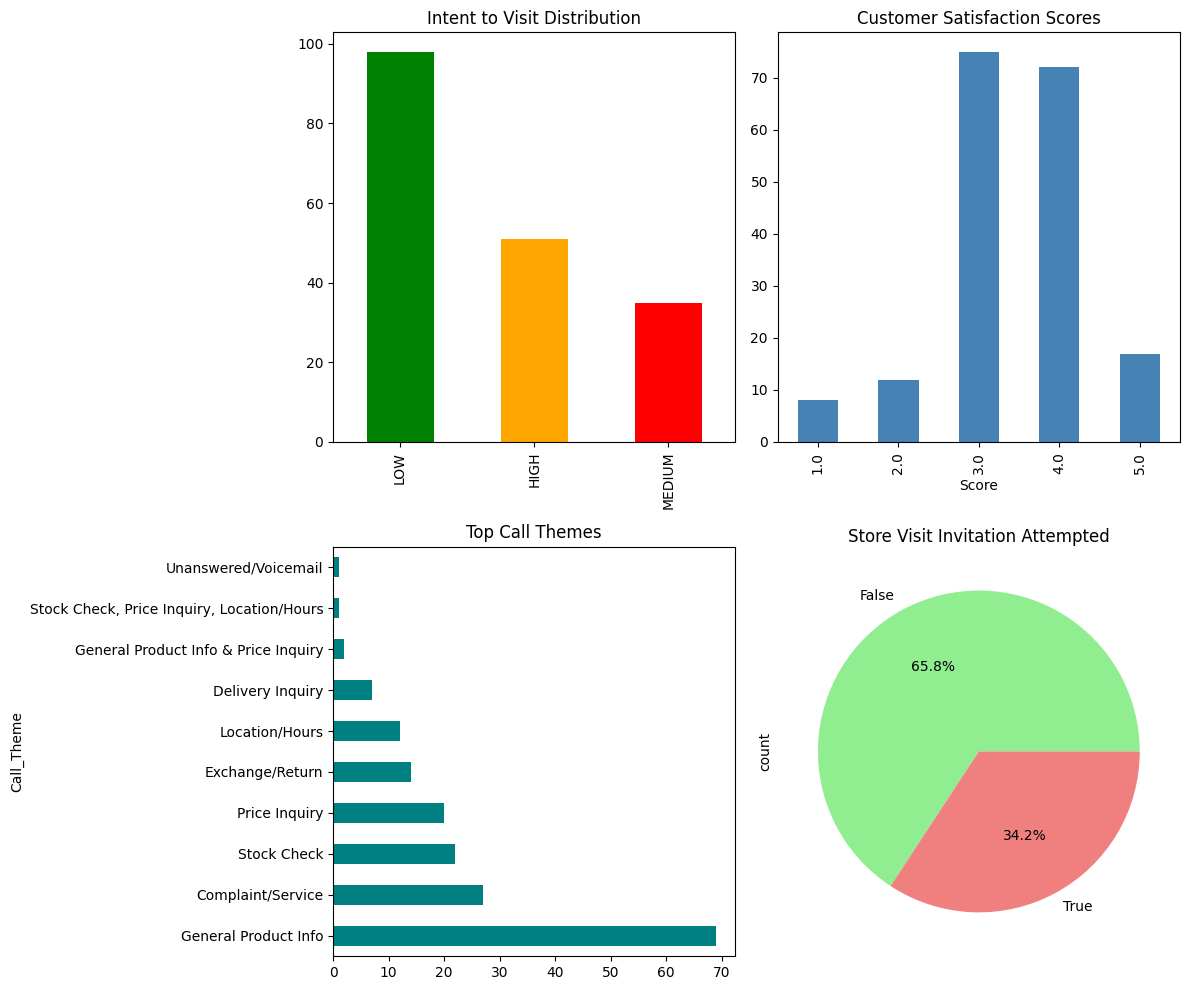

✅ Analytics chart saved!


<Figure size 640x480 with 0 Axes>

In [ ]:
# GMB Call Quality Analysis Pipeline - Google Colab Ready
# ============================================================================
# Copy each section below into separate Colab cells
# ============================================================================

# %% [markdown]
# # 📞 GMB Call Quality Analysis Pipeline
#
# This notebook processes Duroflex store call recordings through Gemini Flash API
# to extract structured quality analysis.
#
# **Features:**
# - ✅ Modular design
# - ✅ Progress bar with ETA
# - ✅ Comprehensive logging
# - ✅ Auto-checkpoint (resume on failure)
# - ✅ Error handling & retry logic

# %% [markdown]
# ## 📦 CELL 1: Setup & Installation

# %%
# CELL 1: INSTALLATION
# Run this cell first!

!pip install -q google-generativeai pandas tqdm requests

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

print("✅ Setup complete!")

# %% [markdown]
# ## ⚙️ CELL 2: Configuration
#
# **⚠️ Update the paths below to match your file locations!**

# %%
# CELL 2: CONFIGURATION
# ================================================
# ⚠️ UPDATE THESE PATHS FOR YOUR FILES ⚠️
# ================================================

CONFIG = {
    # Input/Output Paths (UPDATE THESE!)
    "INPUT_CSV_PATH": "/content/drive/MyDrive/Duroflex/Store Conversion/staff quality proxy via Gmb call pilot.csv",
    "OUTPUT_CSV_PATH": "/content/drive/MyDrive/Duroflex/Store Conversion/staff_quality_analysis_results.csv",
    "CHECKPOINT_PATH": "/content/drive/MyDrive/Duroflex/Store Conversion/analysis_checkpoint.csv",
    "LOG_FILE_PATH": "/content/drive/MyDrive/Duroflex/Store Conversion/analysis_log.txt",

    # Gemini Configuration
    "GEMINI_MODEL": "gemini-flash-latest",

    # Processing Settings
    "RETRY_ATTEMPTS": 3,
    "RETRY_DELAY_SECONDS": 5,
    "RATE_LIMIT_DELAY": 1.0,  # Seconds between API calls

    # Column Names (match your CSV)
    "RECORDING_URL_COLUMN": "Recording URL",
    "OUTPUT_COLUMN": "call_analysis_json",
}

print("✅ Configuration loaded!")
print(f"📁 Input:  {CONFIG['INPUT_CSV_PATH']}")
print(f"📁 Output: {CONFIG['OUTPUT_CSV_PATH']}")

# %% [markdown]
# ## 🔑 CELL 3: API Key Setup
#
# Choose ONE of these methods:
# 1. **Recommended**: Use Colab Secrets (click 🔑 in left sidebar)
# 2. Enter directly when prompted

# %%
# CELL 3: API KEY SETUP

import os

def get_api_key():
    """Get API key from various sources."""

    # Method 1: Try Colab Secrets (Recommended)
    try:
        from google.colab import userdata
        key = userdata.get('GEMINI_API_KEY')
        if key:
            print("✅ API key loaded from Colab Secrets")
            return key
    except:
        pass

    # Method 2: Environment variable
    if os.environ.get('GEMINI_API_KEY'):
        print("✅ API key loaded from environment")
        return os.environ.get('GEMINI_API_KEY')

    # Method 3: Direct input
    from getpass import getpass
    print("🔑 Enter your Gemini API Key:")
    return getpass()

GEMINI_API_KEY = get_api_key()

# %% [markdown]
# ## 📋 CELL 4: Processing Prompt
#
# This prompt instructs Gemini on how to analyze the calls.

# %%
# CELL 4: PROCESSING PROMPT

PROCESSING_PROMPT = '''
You are an expert Retail Operations & Sales Analyst for Duroflex, a premium mattress and sleep solutions brand.

## CONTEXT
You are analyzing a Google My Business (GMB) audio voice call between a potential customer and a Duroflex Store Manager. Unlike video calls, these interactions are purely auditory and often serve as a bridge to a physical store visit. Your analysis will be used to improve 'Call-to-Visit' conversion rates.

## OBJECTIVE
To evaluate the Store Manager's ability to handle inquiries professionally, identify strengths/weaknesses in sales technique, and determine if the agent effectively converts the phone inquiry into a Physical Store Visit.
Note: Some calls may be Service/Post-Sales related.

## STORE CONTEXT
- Store Name: {store_name}
- Location: {locality}, {city}, {state}
- Region: {region}
- Call Date: {call_date}
- Call Duration: {duration} seconds

## RATING SCALE (Use for all scores)
- 1: Poor / Not Attempted
- 2: Below Average
- 3: Average / Met Minimum Standard
- 4: Good / Effective
- 5: Excellent / Exemplary

## ANALYSIS REQUIREMENTS

### Functional Information
- Call_ID: Create using format "CALL_{{store}}_{{date}}_{{hash}}" where hash is first 6 chars of recording URL hash
- Call_Time: Extract from audio if mentioned, otherwise use "Not mentioned"
- Customer_Name: Name of the customer if mentioned
- Agent_Name: Name of the Store Manager/Staff if mentioned
- Store_Location: {locality}, {city}
- Customer_Language: Primary language spoken (English, Hindi, Kannada, Telugu, Tamil, Mix, etc.)
- Agent_Audio_Quality_Rating: 1-5 based on clarity
- Call_Objective_Theme: Main purpose (Stock Check, Price Inquiry, Location/Hours, Complaint/Service, General Product Info, Exchange/Return, Delivery Inquiry)

### Customer Information
- Interest_Category: Mattress, Sofa, Bed, Pillows, Accessories, Multiple, or Service
- Specific_Product_Inquiry: Specific model name or "General"
- Primary_Questions_Asked: List top 3-4 specific questions
- Timeline_to_Purchase: Short (Today/This Week), Medium (2-4 Weeks), Long (>1 Month)
- Customer_Stage_AIDA: Awareness/Interest/Desire/Action
- Intent_to_Visit_Rating: HIGH/MEDIUM/LOW with reasons
- Intent_to_Purchase_Rating: HIGH/MEDIUM/LOW with reasons
- Barriers_to_Conversion: Primary barrier if intent is Low/Medium
- Customer_Satisfaction_Score: 1-5 based on closing sentiment

### Agent Performance Areas
Evaluate these with scores (1-5) and 2-3 bullet point reasons:

**Verbal Product Knowledge:**
- Description_Quality: Did they use descriptive vocabulary to explain the 'feel'?
- Stock_Availability_Check: Did they check system/physical stock confidently?

**The Invitation to Visit:**
- Attempted: Yes/No
- Quality_Rating: Did they explicitly invite to store or share location?

**RELAX Framework:**
- R_Reach_Out: Greeting & Brand Name usage
- E_Explore_Needs: Discovery of user needs/pain points
- L_Link_Experience: Linking need to physical store trial
- A_Add_Value: Mentioning offers/financing/accessories
- X_Express_Closing: Next steps/Logistics

**Soft Skills & Etiquette:**
- Tone_and_Patience: Patience and welcoming tone
- Hold_Management: Professional handling of hold times
- Agent_Language_Fluency_Score: Clear communication in customer's preferred language

### Overall Summary
- Call_Synopsis: 2-3 sentence summary
- Agent_Performance_Summary: Overall assessment
- Next_Action: Specific next step defined
- Top_3_Improvement_Areas: Actionable improvement suggestions

## OUTPUT FORMAT
Return ONLY a valid JSON object matching this exact schema. Do not include any text before or after the JSON:

{{
  "Functional": {{
    "Call_ID": "",
    "Call_Time": "",
    "Customer_Name": "",
    "Agent_Name": "",
    "Store_Location": "",
    "Customer_Language": "",
    "Agent_Audio_Quality_Rating": 0,
    "Call_Objective_Theme": ""
  }},
  "Customer_Information": {{
    "Interest_Category": "",
    "Specific_Product_Inquiry": "",
    "Primary_Questions_Asked": [],
    "Timeline_to_Purchase": "",
    "Customer_Stage_AIDA": "",
    "Intent_to_Visit_Rating": "",
    "Intent_to_Visit_Rating_Reasons": [],
    "Intent_to_Purchase_Rating": "",
    "Intent_to_Purchase_Rating_Reasons": [],
    "Barriers_to_Conversion": "",
    "Customer_Satisfaction_Score": 0,
    "Customer_Satisfaction_Score_Reasons": []
  }},
  "Agent_Areas": {{
    "Verbal_Product_Knowledge": {{
      "Description_Quality_Rating": 0,
      "Description_Quality_Reason": "",
      "Stock_Availability_Check_Rating": 0,
      "Stock_Availability_Check_Reason": ""
    }},
    "The_Invitation_to_Visit": {{
      "Attempted": false,
      "Quality_Rating": 0,
      "Reasons": []
    }},
    "RELAX_Framework": {{
      "R_Reach_Out": {{"Rating": 0, "Reasons": []}},
      "E_Explore_Needs": {{"Rating": 0, "Reasons": []}},
      "L_Link_Experience": {{"Rating": 0, "Reasons": []}},
      "A_Add_Value": {{"Rating": 0, "Reasons": []}},
      "X_Express_Closing": {{"Rating": 0, "Reasons": []}}
    }},
    "SoftSkills_Etiquette": {{
      "Tone_and_Patience_Rating": 0,
      "Hold_Management_Rating": 0,
      "Agent_Language_Fluency_Score": 0,
      "Soft_Skills_Reasons": []
    }},
    "Top_3_Improvement_Areas": []
  }},
  "Overall_Summary": {{
    "Call_Synopsis": "",
    "Agent_Performance_Summary": "",
    "Next_Action": ""
  }},
  "Transcript_Log": [
    {{"Speaker": "", "Text": "", "Timestamp": ""}}
  ]
}}

IMPORTANT:
1. Return ONLY the JSON object, no markdown formatting, no code blocks
2. All scores must be integers 1-5
3. All arrays must have at least one element
4. "Attempted" must be boolean true/false
5. Transcribe the conversation as best as possible in Transcript_Log
'''

print("✅ Processing prompt loaded!")

# %% [markdown]
# ## 🛠️ CELL 5: Core Modules
#
# This cell contains all the core classes and functions.

# %%
# CELL 5: CORE MODULES

import os
import json
import time
import logging
import requests
import pandas as pd
import tempfile  # <--- ADDED
from datetime import datetime
from typing import Optional, Dict, Any, Tuple, List
from tqdm.notebook import tqdm
import google.generativeai as genai
import hashlib
import traceback

# ============================================================================
# LOGGING
# ============================================================================

class Logger:
    """Simple logger with console and file output."""

    def __init__(self, log_file: str = None):
        self.log_file = log_file
        self.start_time = datetime.now()

    def _log(self, level: str, msg: str):
        timestamp = datetime.now().strftime("%H:%M:%S")
        formatted = f"[{timestamp}] {level}: {msg}"
        print(formatted)

        if self.log_file:
            try:
                with open(self.log_file, 'a') as f:
                    f.write(f"{formatted}\n")
            except:
                pass

    def info(self, msg: str):
        self._log("INFO", msg)

    def success(self, msg: str):
        self._log("✅", msg)

    def warning(self, msg: str):
        self._log("⚠️ WARN", msg)

    def error(self, msg: str):
        self._log("❌ ERROR", msg)

    def progress(self, current: int, total: int, msg: str = ""):
        self._log("PROGRESS", f"[{current}/{total}] {msg}")

# ============================================================================
# AUDIO HANDLER
# ============================================================================

class AudioHandler:
    """Downloads and validates audio files."""

    def __init__(self, logger: Logger, timeout: int = 60):
        self.logger = logger
        self.timeout = timeout

    def download(self, url: str) -> Tuple[Optional[bytes], Optional[str]]:
        """Download audio from URL. Returns (audio_bytes, error_msg)."""
        try:
            self.logger.info(f"Downloading: {url[:60]}...")
            # Use stream to handle larger files better, though we read content immediately here
            response = requests.get(url, timeout=self.timeout)
            response.raise_for_status()

            audio_data = response.content

            if len(audio_data) < 1000:
                return None, "Audio file too small"

            self.logger.info(f"Downloaded {len(audio_data):,} bytes")
            return audio_data, None

        except requests.exceptions.Timeout:
            return None, "Download timeout"
        except requests.exceptions.RequestException as e:
            return None, f"Download error: {str(e)}"
        except Exception as e:
            return None, f"Unexpected error: {str(e)}"

# ============================================================================
# GEMINI ANALYZER (UPDATED FOR FILE API)
# ============================================================================

class GeminiAnalyzer:
    """Analyzes audio using Gemini API via File Upload (Prevents Timeouts)."""

    def __init__(self, api_key: str, model: str, logger: Logger):
        self.logger = logger
        self.model_name = model

        # Initialize API
        genai.configure(api_key=api_key)

        # Configure model
        generation_config = genai.GenerationConfig(
            temperature=0.1,
            top_p=0.95,
            max_output_tokens=8192,
            response_mime_type="application/json"
        )

        self.model = genai.GenerativeModel(
            model_name=model,
            generation_config=generation_config
        )

        self.logger.success(f"Gemini initialized: {model}")

    def analyze(
        self,
        audio_data: bytes,
        row_data: Dict,
        prompt_template: str
    ) -> Tuple[Optional[Dict], Optional[str]]:
        """Analyze audio call. Returns (analysis_dict, error_msg)."""

        temp_path = None
        uploaded_file = None

        try:
            # 1. Save bytes to a temporary file locally
            # We assume MP3/WAV. Using .mp3 covers most generic audio cases for Gemini.
            with tempfile.NamedTemporaryFile(suffix=".mp3", delete=False) as temp_file:
                temp_file.write(audio_data)
                temp_path = temp_file.name

            # 2. Upload to Gemini File API
            # self.logger.info("Uploading audio to Gemini storage...")
            uploaded_file = genai.upload_file(temp_path, mime_type="audio/mp3")

            # Wait for processing (usually instant for audio)
            while uploaded_file.state.name == "PROCESSING":
                time.sleep(1)
                uploaded_file = genai.get_file(uploaded_file.name)

            if uploaded_file.state.name == "FAILED":
                return None, "Gemini File Processing Failed"

            # 3. Prepare prompt
            prompt = prompt_template.format(
                store_name=row_data.get('Store Name', 'Unknown'),
                locality=row_data.get('Locality', 'Unknown'),
                city=row_data.get('City', 'Unknown'),
                state=row_data.get('State', 'Unknown'),
                region=row_data.get('Region', 'Unknown'),
                call_date=row_data.get('Date', 'Unknown'),
                duration=row_data.get('Duration', 'Unknown')
            )

            # 4. Generate Content (Prompt + File Reference)
            # self.logger.info("Sending prompt to model...")
            response = self.model.generate_content([prompt, uploaded_file])

            if not response.text:
                return None, "Empty response from Gemini"

            # 5. Parse JSON
            json_text = response.text.strip()
            if json_text.startswith("```"):
                json_text = json_text.split("```")[1]
                if json_text.startswith("json"):
                    json_text = json_text[4:]
            json_text = json_text.strip()

            analysis = json.loads(json_text)
            return analysis, None

        except json.JSONDecodeError as e:
            return {"raw_response": response.text, "parse_error": str(e)}, None
        except Exception as e:
            return None, f"API error: {str(e)}"

        finally:
            # 6. CLEANUP (Crucial!)
            # Delete local temp file
            if temp_path and os.path.exists(temp_path):
                os.remove(temp_path)

            # Delete remote file from Gemini storage to avoid clutter/limits
            if uploaded_file:
                try:
                    uploaded_file.delete()
                except:
                    pass

    def analyze_with_retry(
        self,
        audio_data: bytes,
        row_data: Dict,
        prompt_template: str,
        retries: int = 3,
        delay: int = 5
    ) -> Tuple[Optional[Dict], Optional[str]]:
        """Analyze with retry logic."""

        last_error = None

        for attempt in range(1, retries + 1):
            result, error = self.analyze(audio_data, row_data, prompt_template)

            if result is not None:
                return result, None

            last_error = error

            if attempt < retries:
                self.logger.warning(f"Attempt {attempt} failed. Retrying in {delay}s...")
                time.sleep(delay * attempt)

        return None, f"All {retries} attempts failed: {last_error}"

# ============================================================================
# DATA HANDLER
# ============================================================================

class DataHandler:
    """Handles CSV operations and checkpointing."""

    def __init__(self, config: Dict, logger: Logger):
        self.config = config
        self.logger = logger

    def load_csv(self) -> pd.DataFrame:
        """Load input CSV."""
        path = self.config["INPUT_CSV_PATH"]
        self.logger.info(f"Loading: {path}")
        df = pd.read_csv(path)
        self.logger.info(f"Loaded {len(df)} rows")
        return df

    def load_checkpoint(self) -> Optional[pd.DataFrame]:
        """Load checkpoint if exists."""
        path = self.config["CHECKPOINT_PATH"]
        if os.path.exists(path):
            self.logger.info("Found checkpoint, loading...")
            return pd.read_csv(path)
        return None

    def save_checkpoint(self, df: pd.DataFrame):
        """Save checkpoint."""
        df.to_csv(self.config["CHECKPOINT_PATH"], index=False)

    def save_final(self, df: pd.DataFrame):
        """Save final results."""
        path = self.config["OUTPUT_CSV_PATH"]
        df.to_csv(path, index=False)
        self.logger.success(f"Saved to: {path}")

    def get_unprocessed(self, df: pd.DataFrame) -> List[int]:
        """Get indices of unprocessed rows."""
        col = self.config["OUTPUT_COLUMN"]

        if col not in df.columns:
            return list(df.index)

        return df[df[col].isna() | (df[col] == '')].index.tolist()

print("✅ Core modules loaded! (File API Enabled)")

# %% [markdown]
# ## 🚀 CELL 6: Main Pipeline
#
# This is the main processing pipeline that ties everything together.

# %%
# CELL 6: MAIN PIPELINE

class CallAnalysisPipeline:
    """Main orchestrator for call analysis."""

    def __init__(self, config: Dict, api_key: str, prompt: str):
        self.config = config
        self.api_key = api_key
        self.prompt = prompt

        # Initialize components
        self.logger = Logger(config["LOG_FILE_PATH"])
        self.data_handler = DataHandler(config, self.logger)
        self.audio_handler = AudioHandler(self.logger)
        self.analyzer = GeminiAnalyzer(api_key, config["GEMINI_MODEL"], self.logger)

        # Stats
        self.stats = {
            "total": 0,
            "processed": 0,
            "success": 0,
            "failed": 0,
            "skipped": 0
        }

    def process_row(self, row: pd.Series) -> Tuple[Optional[str], Optional[str]]:
        """Process single row. Returns (json_string, error_msg)."""

        url_col = self.config["RECORDING_URL_COLUMN"]
        url = row.get(url_col)

        if not url or pd.isna(url):
            return None, "No recording URL"

        # Download audio
        audio_data, error = self.audio_handler.download(url)
        if error:
            return None, f"Download: {error}"

        # Analyze
        row_data = row.to_dict()
        analysis, error = self.analyzer.analyze_with_retry(
            audio_data,
            row_data,
            self.prompt,
            retries=self.config["RETRY_ATTEMPTS"],
            delay=self.config["RETRY_DELAY_SECONDS"]
        )

        if error:
            return None, f"Analysis: {error}"

        # Convert to JSON string
        return json.dumps(analysis, ensure_ascii=False), None

    def run(self, resume: bool = True) -> pd.DataFrame:
        """Run the full pipeline."""

        print("\n" + "="*60)
        print("📞 GMB CALL ANALYSIS PIPELINE")
        print("="*60 + "\n")

        start_time = datetime.now()

        # Load data
        if resume:
            checkpoint = self.data_handler.load_checkpoint()
            df = checkpoint if checkpoint is not None else self.data_handler.load_csv()
        else:
            df = self.data_handler.load_csv()

        # Initialize output column
        output_col = self.config["OUTPUT_COLUMN"]
        if output_col not in df.columns:
            df[output_col] = None

        # Get unprocessed rows
        unprocessed = self.data_handler.get_unprocessed(df)

        self.stats["total"] = len(df)
        self.stats["skipped"] = len(df) - len(unprocessed)

        print(f"📊 Total rows: {len(df)}")
        print(f"✅ Already processed: {self.stats['skipped']}")
        print(f"🔄 To process: {len(unprocessed)}\n")

        if len(unprocessed) == 0:
            print("🎉 All rows already processed!")
            return df

        # Process with progress bar
        with tqdm(total=len(unprocessed), desc="Processing calls") as pbar:
            for idx in unprocessed:
                row = df.loc[idx]
                store = row.get('Store Name', 'Unknown')

                try:
                    json_result, error = self.process_row(row)

                    if error:
                        self.logger.warning(f"Row {idx} ({store}): {error}")
                        df.at[idx, output_col] = json.dumps({
                            "error": error,
                            "processed_at": datetime.now().isoformat()
                        })
                        self.stats["failed"] += 1
                    else:
                        df.at[idx, output_col] = json_result
                        self.stats["success"] += 1

                    self.stats["processed"] += 1

                except Exception as e:
                    self.logger.error(f"Row {idx}: {e}")
                    df.at[idx, output_col] = json.dumps({
                        "error": str(e),
                        "processed_at": datetime.now().isoformat()
                    })
                    self.stats["failed"] += 1
                    self.stats["processed"] += 1

                # Save checkpoint after each row
                self.data_handler.save_checkpoint(df)

                # Rate limiting
                time.sleep(self.config["RATE_LIMIT_DELAY"])

                pbar.update(1)
                pbar.set_postfix({
                    "✅": self.stats["success"],
                    "❌": self.stats["failed"]
                })

        # Save final results
        self.data_handler.save_final(df)

        # Print summary
        duration = datetime.now() - start_time

        print("\n" + "="*60)
        print("📊 PROCESSING COMPLETE")
        print("="*60)
        print(f"Total rows:      {self.stats['total']}")
        print(f"Processed:       {self.stats['processed']}")
        print(f"Successful:      {self.stats['success']}")
        print(f"Failed:          {self.stats['failed']}")
        print(f"Skipped:         {self.stats['skipped']}")
        print(f"Duration:        {duration}")
        print(f"Output:          {self.config['OUTPUT_CSV_PATH']}")
        print("="*60 + "\n")

        return df

print("✅ Pipeline class loaded!")

# %% [markdown]
# ## ▶️ CELL 7: RUN THE PIPELINE
#
# **Execute this cell to start processing!**

# %%
# CELL 7: RUN THE PIPELINE
# ================================================
# ▶️ EXECUTE THIS CELL TO START PROCESSING
# ================================================

# Create and run pipeline
pipeline = CallAnalysisPipeline(
    config=CONFIG,
    api_key=GEMINI_API_KEY,
    prompt=PROCESSING_PROMPT
)

# Run with resume=True to continue from last checkpoint
result_df = pipeline.run(resume=True)

# Display first few results
print("\n📋 Sample Results:")
result_df.head()

# %% [markdown]
# ## 📊 CELL 8: Extract Metrics (Optional)
#
# Run this to extract key metrics into separate columns for analysis.

# %%
# CELL 8: EXTRACT METRICS (OPTIONAL)

def extract_metrics(df: pd.DataFrame, json_col: str = "call_analysis_json") -> pd.DataFrame:
    """Extract key metrics from JSON into separate columns."""

    metrics = []

    for idx, row in df.iterrows():
        json_str = row.get(json_col)
        metric = {"index": idx}

        if not json_str or pd.isna(json_str):
            metric["analysis_success"] = False
            metrics.append(metric)
            continue

        try:
            data = json.loads(json_str)

            if "error" not in data:
                func = data.get("Functional", {})
                cust = data.get("Customer_Information", {})
                agent = data.get("Agent_Areas", {})
                summary = data.get("Overall_Summary", {})

                metric.update({
                    "Customer_Language": func.get("Customer_Language"),
                    "Call_Theme": func.get("Call_Objective_Theme"),
                    "Interest_Category": cust.get("Interest_Category"),
                    "Intent_to_Visit": cust.get("Intent_to_Visit_Rating"),
                    "Intent_to_Purchase": cust.get("Intent_to_Purchase_Rating"),
                    "Customer_Satisfaction": cust.get("Customer_Satisfaction_Score"),
                    "Invite_Attempted": agent.get("The_Invitation_to_Visit", {}).get("Attempted"),
                    "Invite_Quality": agent.get("The_Invitation_to_Visit", {}).get("Quality_Rating"),
                    "Next_Action": summary.get("Next_Action"),
                    "Call_Synopsis": summary.get("Call_Synopsis"),
                    "analysis_success": True
                })
            else:
                metric["analysis_success"] = False
                metric["error"] = data.get("error")

        except Exception as e:
            metric["analysis_success"] = False
            metric["error"] = str(e)

        metrics.append(metric)

    return pd.DataFrame(metrics)

# Extract and merge metrics
metrics_df = extract_metrics(result_df)
final_df = result_df.merge(metrics_df, left_index=True, right_on='index', how='left')

# Save metrics version
metrics_output = CONFIG["OUTPUT_CSV_PATH"].replace(".csv", "_with_metrics.csv")
final_df.to_csv(metrics_output, index=False)
print(f"✅ Saved with metrics: {metrics_output}")

# Show summary
print("\n📊 Analysis Summary:")
print(f"Success rate: {metrics_df['analysis_success'].mean()*100:.1f}%")
print(f"\nIntent to Visit Distribution:")
print(metrics_df['Intent_to_Visit'].value_counts())

# %% [markdown]
# ## 🔍 CELL 9: View Individual Results (Optional)

# %%
# CELL 9: VIEW INDIVIDUAL RESULTS

def view_analysis(df: pd.DataFrame, row_index: int, json_col: str = "call_analysis_json"):
    """Pretty print analysis for a specific row."""

    row = df.loc[row_index]
    print(f"Store: {row.get('Store Name', 'N/A')}")
    print(f"City: {row.get('City', 'N/A')}")
    print(f"Date: {row.get('Date', 'N/A')}")
    print(f"Duration: {row.get('Duration', 'N/A')} seconds")
    print("-" * 50)

    json_str = row.get(json_col)
    if json_str and not pd.isna(json_str):
        data = json.loads(json_str)
        print(json.dumps(data, indent=2, ensure_ascii=False))
    else:
        print("No analysis available")

# View analysis for row 0 (change index as needed)
view_analysis(result_df, 0)

# %% [markdown]
# ## 📈 CELL 10: Quick Analytics (Optional)

# %%
# CELL 10: QUICK ANALYTICS

import matplotlib.pyplot as plt

# Only run if we have metrics
if 'metrics_df' in dir():
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    # Intent to Visit
    if 'Intent_to_Visit' in metrics_df.columns:
        metrics_df['Intent_to_Visit'].value_counts().plot(
            kind='bar', ax=axes[0,0], color=['green', 'orange', 'red']
        )
        axes[0,0].set_title('Intent to Visit Distribution')
        axes[0,0].set_xlabel('')

    # Customer Satisfaction
    if 'Customer_Satisfaction' in metrics_df.columns:
        metrics_df['Customer_Satisfaction'].value_counts().sort_index().plot(
            kind='bar', ax=axes[0,1], color='steelblue'
        )
        axes[0,1].set_title('Customer Satisfaction Scores')
        axes[0,1].set_xlabel('Score')

    # Call Themes
    if 'Call_Theme' in metrics_df.columns:
        metrics_df['Call_Theme'].value_counts().head(10).plot(
            kind='barh', ax=axes[1,0], color='teal'
        )
        axes[1,0].set_title('Top Call Themes')

    # Invite Attempted
    if 'Invite_Attempted' in metrics_df.columns:
        metrics_df['Invite_Attempted'].value_counts().plot(
            kind='pie', ax=axes[1,1], autopct='%1.1f%%', colors=['lightgreen', 'lightcoral']
        )
        axes[1,1].set_title('Store Visit Invitation Attempted')

    plt.tight_layout()
    plt.show()

    # Save figure
    plt.savefig(CONFIG["OUTPUT_CSV_PATH"].replace(".csv", "_analytics.png"), dpi=150, bbox_inches='tight')
    print("✅ Analytics chart saved!")
else:
    print("⚠️ Run Cell 8 first to generate metrics")